## Problem 4.1 – Harmonic polymer chain 

This script simulates a 1D linear polymer modeled as a harmonic chain using the Velocity Verlet integrator.

- Harmonic bonds with rest length $\ell$ and stiffness $k=1$
- Velocities from Maxwell-Boltzmann distribution at time intervals $\Delta t = \sqrt{m/k}$
- Supports two initial configurations:
  - Fully stretched linear chain
  - Fully collapsed chain (all $r_i = 0$)


Units:
- Length: $\ell$
- Time: $\omega_0^{-1} = \sqrt{m/k}$
- Energy: $\epsilon = k\ell^2$

### a) Compute and plot:
  - Radius of gyration $R_g(t)$
  - End-to-end distance $R_e(t)$
  - Potential energy per particle $E_{pot}/N$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from integrators.velocity_verlet import velocity_verlet_simulation

# ---- Parameters ----
m = 1.0
k = 1.0
epsilon = 1.0
omega_0_inv = np.sqrt(m / k)
dt = 0.01 * omega_0_inv
t_sim = 5000 * omega_0_inv  

# ---- Run simulations using unified integrator
res_linear = velocity_verlet_simulation(
    N=50,
    dt=dt,
    t_sim=t_sim,
    k=k,
    m=m,
    beta=1 / epsilon,
    config="linear",
    random_momenta=True,
    return_energy=False,
    track_observables=False,
    seed=None
)

res_collapsed = velocity_verlet_simulation(
    N=50,
    dt=dt,
    t_sim=t_sim,
    k=k,
    m=m,
    beta=1 / epsilon,
    config="collapsed",
    random_momenta=True,
    return_energy=False,
    track_observables=False,
    seed=None
)

# Extract trajectories
r_traj_linear = res_linear["r_traj"]
r_traj_collapsed = res_collapsed["r_traj"]


Integrating: 100%|████████████████████| 500000/500000 [02:29<00:00, 3346.72it/s]


In [2]:
from utils.observables import compute_Re, compute_Rg2, compute_U

Re_linear = compute_Re(r_traj_linear)
Rg2_linear = compute_Rg2(r_traj_linear)
U_linear = compute_U(r_traj_linear, k=1.0)


Re_collapsed = compute_Re(r_traj_collapsed)
Rg2_collapsed = compute_Rg2(r_traj_collapsed)
U_collapsed = compute_U(r_traj_collapsed, k=1.0)

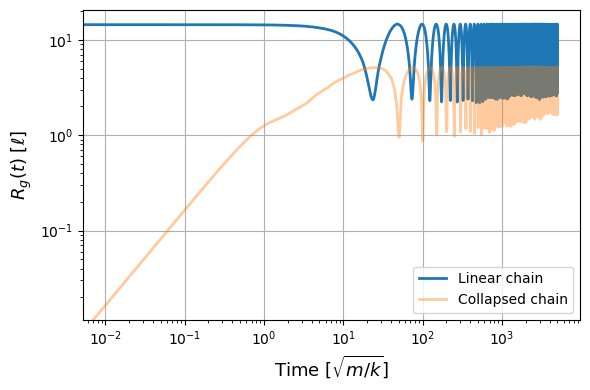

In [3]:
# ---Radius of gyration ---
time = np.arange(int(t_sim / dt)) * dt
plt.figure(figsize=(6, 4))
plt.plot(time, np.sqrt(Rg2_linear[:]), label="Linear chain", lw=2.)
plt.plot(time, np.sqrt(Rg2_collapsed[:]), label="Collapsed chain", lw=2., linestyle='-', alpha=0.4)

plt.xlabel(r"Time $[\sqrt{m/k}]$", fontsize=13)
plt.ylabel(r"$R_g(t)$ $[\ell]$", fontsize=13)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


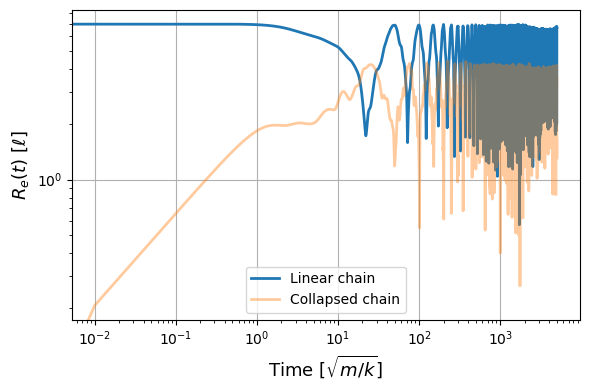

In [4]:
# --- End to end distance ---
plt.figure(figsize=(6, 4))
plt.plot(time, np.sqrt(Re_linear[:]), label="Linear chain", lw=2)
plt.plot(time, np.sqrt(Re_collapsed[:]), label="Collapsed chain", lw=2, linestyle='-', alpha=0.4)

plt.xlabel(r"Time $[\sqrt{m/k}]$", fontsize=13)
plt.ylabel(r"$R_e(t)$ $[\ell]$", fontsize=13)
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


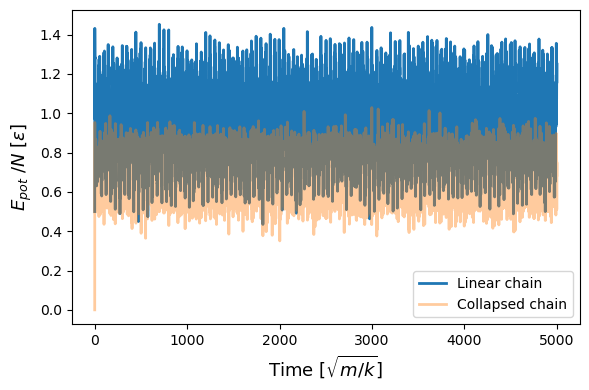

In [5]:
# --- Potential energy ---
plt.figure(figsize=(6, 4))
plt.plot(time, U_linear, label="Linear chain", lw=2)
plt.plot(time, U_collapsed, label="Collapsed chain", lw=2, linestyle='-', alpha=0.4)
plt.xlabel(r"Time $[\sqrt{m/k}]$", fontsize=13)
plt.ylabel("$E_{pot}~/ N$ $[\epsilon]$", fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

### b) Time average observables and uncertainties

Estimate the equilibrium values of key observables for a polymer chain using multiple independent simulations, and quantify their statistical uncertainties. The computed quantities are:

- $\langle R_g^2 \rangle$ : Mean squared radius of gyration  
- $\langle R_e^2 \rangle$: Mean squared end-to-end distance  
- $\langle E_{pot} \rangle / N $: Average potential energy per particle



In [7]:
from utils.observables import time_average_observables

N_runs = 5
Rg2_vals, Re2_vals, U_vals = [], [], []

for seed in range(N_runs):
    r_traj = velocity_verlet_simulation(
    N=50,
    dt=dt,
    t_sim=t_sim,
    k=k,
    m=m,
    beta=1 / epsilon,
    config="linear",
    random_momenta=True,
    return_energy=False,
    track_observables=False,
    seed=seed
)
    Rg2, Re2, U = time_average_observables(r_traj["r_traj"], k=k, t_cutoff=1000, dt=dt)
    Rg2_vals.append(Rg2)
    Re2_vals.append(Re2)
    U_vals.append(U)


Integrating: 100%|████████████████████| 500000/500000 [02:29<00:00, 3336.75it/s]


In [8]:
from utils.help_functions import compute_mean_and_se

# Compute all statistics
mean_Rg2, se_Rg2 = compute_mean_and_se(Rg2_vals)
mean_Re2, se_Re2 = compute_mean_and_se(Re2_vals)
mean_U,   se_U   = compute_mean_and_se(U_vals)
sim = mean_Re2/mean_Rg2
theo = 6*50/(50+1)

print(f"{'Observable':<15}{'Mean ± SE':>20}")
print("-" * 35)
print(f"{'Rg^2':<20}{mean_Rg2:7.1f} ± {se_Rg2:4.1f}")
print(f"{'Re^2':<20}{mean_Re2:7.1f} ± {se_Re2:4.1f}")
print(f"{'U/N':<20}{mean_U:7.3f} ± {se_U:5.3f}")

Observable                Mean ± SE
-----------------------------------
Rg^2                  114.1 ±  1.1
Re^2                  880.3 ±  6.9
U/N                   0.986 ± 0.054


### c) Study the radius of gyration

In [9]:
# --- Parameters ---
N_values = [10, 50, 100, 150, 200, 300]


# --- Storage ---
Rg2_curves = []

print("Simulating Rg^2(t) for various N...")
for N in N_values:
    r_traj = velocity_verlet_simulation(N, dt=dt,t_sim=t_sim,k=k,m=m,beta=1 / epsilon,config="linear",random_momenta=True,return_energy=False,track_observables=False,seed=None)
    Rg = compute_Rg2(r_traj["r_traj"])
    Rg2_curves.append(Rg)
Rg2_curves = np.array(Rg2_curves)  # shape (n_N, n_times)

Simulating Rg^2(t) for various N...


Integrating: 100%|█████████████████████| 500000/500000 [15:47<00:00, 527.84it/s]


/var/folders/fv/fscghd1d26q_plpy56sxv4dr0000gn/T/ipykernel_24791/4181912575.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/giorgiamarcelli/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


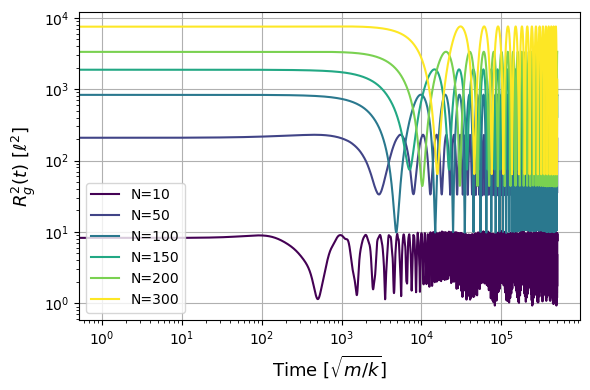

In [10]:
# --- Plot Rg²(t) for all N ---
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, len(N_values)))

plt.figure(figsize=(6, 4))
for i, (N, color) in enumerate(zip(N_values, colors)):
    plt.plot(Rg2_curves[i], label=f"N={N}", color=color)
    

plt.xlabel(r"Time $[\sqrt{m/k}]$", fontsize=13)
plt.ylabel(r"$R_g^2(t)$ $[\ell^2]$", fontsize=13)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

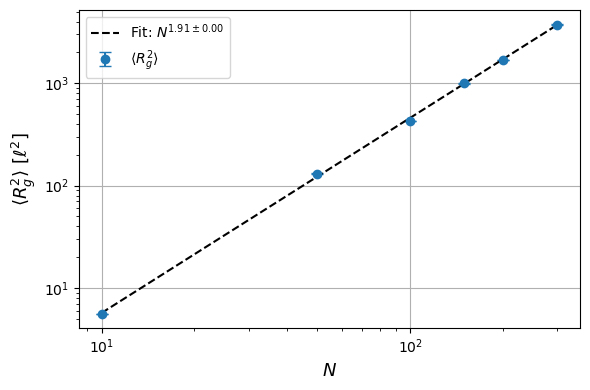

In [11]:
from scipy.optimize import curve_fit

t_cutoff = 1e3
cut_idx = int(t_cutoff / dt)

# --- Step 1: Compute time-averaged Rg^2 and SE after cutoff ---
Rg2_avg = []
Rg2_err = []

for curve in Rg2_curves:
    values = curve[cut_idx:]
    mean = np.mean(values)
    stderr = np.std(values, ddof=1) / np.sqrt(len(values)-1)
    Rg2_avg.append(mean)
    Rg2_err.append(stderr)

Rg2_avg = np.array(Rg2_avg)
Rg2_err = np.array(Rg2_err)
N_values = np.array(N_values)

# --- Step 2: Fit to power law with error weighting ---
def power_law(N, A, alpha):
    return A * N**alpha

popt, pcov = curve_fit(power_law, N_values, Rg2_avg, sigma=Rg2_err, absolute_sigma=True)
A_fit, alpha_fit = popt
A_err, alpha_err = np.sqrt(np.diag(pcov))

# --- Step 3: Plot with error bars and fitted curve ---
plt.figure(figsize=(6, 4))
plt.errorbar(N_values, Rg2_avg, yerr=Rg2_err, fmt='o', capsize=4, label=r"$\langle R_g^2 \rangle$")
plt.loglog(N_values, power_law(N_values, *popt), 'k--',
           label=fr"Fit: $N^{{{alpha_fit:.2f} \pm {alpha_err:.2f}}}$")

plt.xlabel("$N$", fontsize=13)
plt.ylabel(r"$\langle R_g^2 \rangle$ $[\ell^2]$", fontsize=13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### d) Please take a look at pdf file

In [12]:
print(f"{'{Re^2/Rg^2}_sim':<20}{sim:7.1f} ")
print(f"{'{Re^2/Rg^2}_theo':<20}{theo:7.1f} ")

{Re^2/Rg^2}_sim         7.7 
{Re^2/Rg^2}_theo        5.9 
